# Term Project (Group 34)

---

**Anis, Emilia, Eric, Peter**

## Introduction

### Background

The Pacific Laboratory for Artificial Intelligence is a research group within the department of computer science at University of British Columbia, led by Frank Wood. As part of their work, they have set up a Minecraft server where they aim to collect data about player's actions within the game. To run this project, they need to know how to target their recruitment efforts and make sure they have enough resources. This report aims to support the research group with a data analysis to help them target their recruitment efforts by investigating what player characteristics and behaviours are most predictive of subscribing to a game-related newspaper, and how these features differ between various player types. More specifically, the following research question will be investigated.

> *Can player's age, experience, gender, and number of hours played predict subscription to a game-related newspaper?*

### Data description

For this analysis, a dataset with information about 196 players using the server, is used. The data is collected within the server, with the player's consent. the dataset has the dimensions 196 x 7 and contains missing values. For each player, the following variables (Figure 1) are recorded.

| Variable name    | Type | Description |
| -------- | ------- | ------- |
| experience  | Character    | The player's experience level (Amateur/ Beginner/ Regular/ Veteran/ Pro)  |
| subscribe | Logical     | Does the player subscribe to a game-related newspaper (TRUE/ FALSE) |
| hashedEmail    | Character    | Unique hash-code representing the player's email |
| played_hours    | Double    | Total number of hours played |
| name    | Character    | Player's name |
| gender    | Character    | Player's gender (Female/ Male) |
| Age    | Double    | Player's age |
<center>
Figure 1.
</center>

## Methods & Results

In the following section, after cleaning and exploring the datatset, we will use K-Nearest Neighbors (KNN) classification to predict whether a player subscribes to a newsletter based on their age, played hours, gender and experience level. We have chosen KNN as the response variable (subscribe) is binary making it suitable for a classification problem. Moreover, the relationship between the explanatory variables is non-linear which KNN classification handles well unlike linear regression.

#### Load libraries

In [1]:
library(tidyverse)
library(tidymodels)

set.seed(10)

── Attaching core tidyverse packages ───────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.2
✔ ggplot2   3.5.2     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ─────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ─────────────────────────────────────────────────────────────────────────────────────────────── tidymodels 1.4.1 ──

✔ broom        1.0.9     ✔ rsample      1.3.1
✔ dials        1.4.2     ✔ tailor       0.1.0
✔ infer        1.0.9     ✔ tune         2.0.1
✔ modeldata    1.5.1     ✔ workflows    1.3.0
✔ parsnip      1.4.0     ✔ workflowsets

#### Load dataset

In [2]:
players <- read_csv("https://raw.githubusercontent.com/avahbot/dsci-100-term-project-final/f97d07b1dd5ef727789e46934ab9e205e11d6c3d/data/players.csv")

Rows: 196 Columns: 7
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
head(players, 10)

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17
Regular,TRUE,8e594b8953193b26f498db95a508b03c6fe1c24bb5251d392c18a0da9a722807,0.0,Luna,Female,19
Amateur,FALSE,1d2371d8a35c8831034b25bda8764539ab7db0f63938696917c447128a2540dd,0.0,Emerson,Male,21
Amateur,TRUE,8b71f4d66a38389b7528bb38ba6eb71157733df7d1740371852a797ae97d82d1,0.1,Natalie,Male,47


### Wrangling and Cleaning of the Data

With a focus on the variables age, experience, gender, hours played, and the predictor subscribe, we first cleaned and wrangled the data to create a tidy dataset (Figure 2) for analysis. The original dataset was filtered to remove rows with NA values, and only the key variables listed above were retained. Finally, several variables were loaded with incorrect datatypes when reading the CSV, so we reassigned them appropriately. In particular, experience and gender were set as factor variables.

In [4]:
tidy_players <- players |>
                filter(!is.na(Age)) |>
                mutate(
                     age = as.integer(Age),
                     played_hours = as.numeric(played_hours),
                     experience = as.factor(experience),
                     gender = as.factor(gender),
                     subscribe = as.factor(subscribe) # need to use subscribe as factor to predict with k-nn
                 ) |>
                select(age, played_hours, experience, gender, subscribe)

In [5]:
head(tidy_players, 10)

age,played_hours,experience,gender,subscribe
<int>,<dbl>,<fct>,<fct>,<fct>
9,30.3,Pro,Male,TRUE
17,3.8,Veteran,Male,TRUE
17,0.0,Veteran,Male,FALSE
21,0.7,Amateur,Female,TRUE
21,0.1,Regular,Male,TRUE
17,0.0,Amateur,Female,TRUE
19,0.0,Regular,Female,TRUE
21,0.0,Amateur,Male,FALSE
47,0.1,Amateur,Male,TRUE


                  Figure 2.

#### Summary statistics

The numerical variables in the dataset, player's age and number of played hours, can be summarized with the table below (Figure 3).

In [6]:
summary <- summarize(tidy_players, 
         min_played_hours = round(min(played_hours, na.rm = TRUE), 2),
         max_played_hours = round(max(played_hours, na.rm = TRUE), 2),
         mean_played_hours = round(mean(played_hours, na.rm = TRUE), 2),
         sd_played_hours = round(sd(played_hours, na.rm = TRUE), 2),
         min_age = round(min(age, na.rm = TRUE), 2),
         max_age = round(max(age, na.rm = TRUE), 2),
         mean_age = round(mean(age, na.rm = TRUE), 2),
         sd_age = round(sd(age, na.rm = TRUE), 2))

summary_table <- tibble(
  variable = c("played_hours", "Age"),
  min  = c(summary$min_played_hours, summary$min_age),
  max  = c(summary$max_played_hours, summary$max_age),
  mean = c(summary$mean_played_hours, summary$mean_age),
  std   = c(summary$sd_played_hours, summary$sd_age)
)

summary_table

variable,min,max,mean,std
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
played_hours,0,223.1,5.90,28.50
Age,9,58.0,21.14,7.39


               Figure 3.

### Exploratory Visualisations

Before conducting the analysis, we first created three visualisations of the dataset to support exploratory data analysis. This allows us to better understand the structure of the data, how we should approach the classification task, and whether any additional tidying of the data are necessary before proceeding.

#### Age vs Played Hours of Plaicraft Players

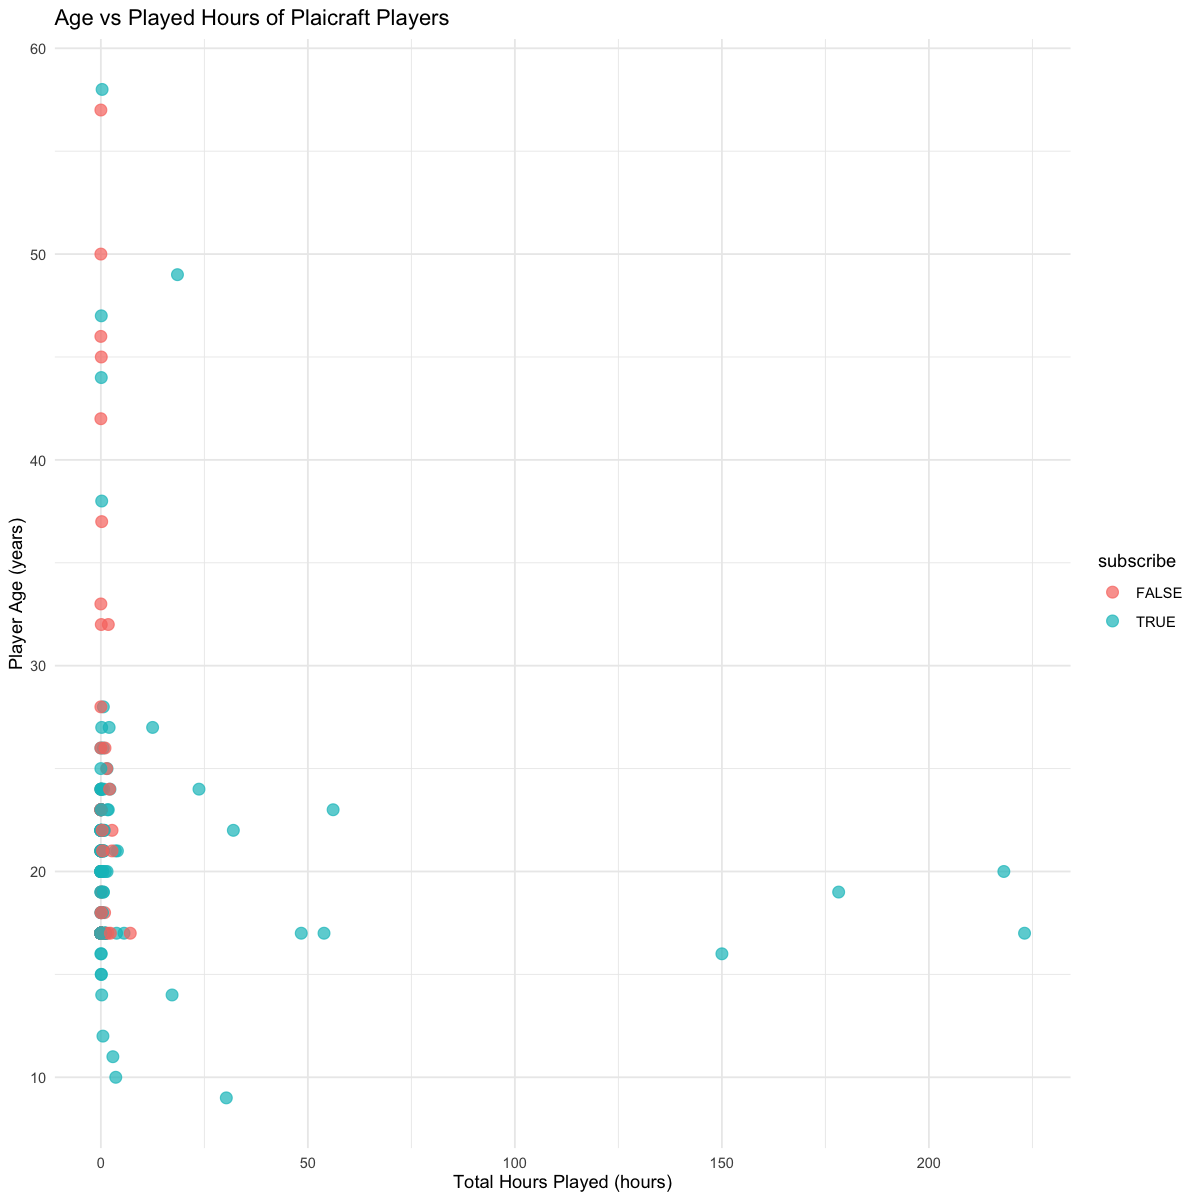

In [7]:
options(repr.plot.width = 10, repr.plot.height = 10)

scatter_plot <- tidy_players |>
                ggplot(aes(x = played_hours, y = age, colour = subscribe)) +
                geom_point(alpha = 0.7, size = 3) +
                labs(
                    title = "Age vs Played Hours of Plaicraft Players",
                    x = "Total Hours Played (hours)",
                    y = "Player Age (years)"
                ) +
                theme_minimal()

scatter_plot

                   Figure 4.

**Figure 4 Insights:**
* Non-subscribed players never exceed a total playtime of 13 hours.
* Many non-subscribed players cluster near zero total playtime, indicating minimal engagement.
* Some subscribed players have extremely high total playtimes (over 200 hours), which heavily inflates the average playtime for this group.

#### Ratio of Subscribed Players per Each Experience Level

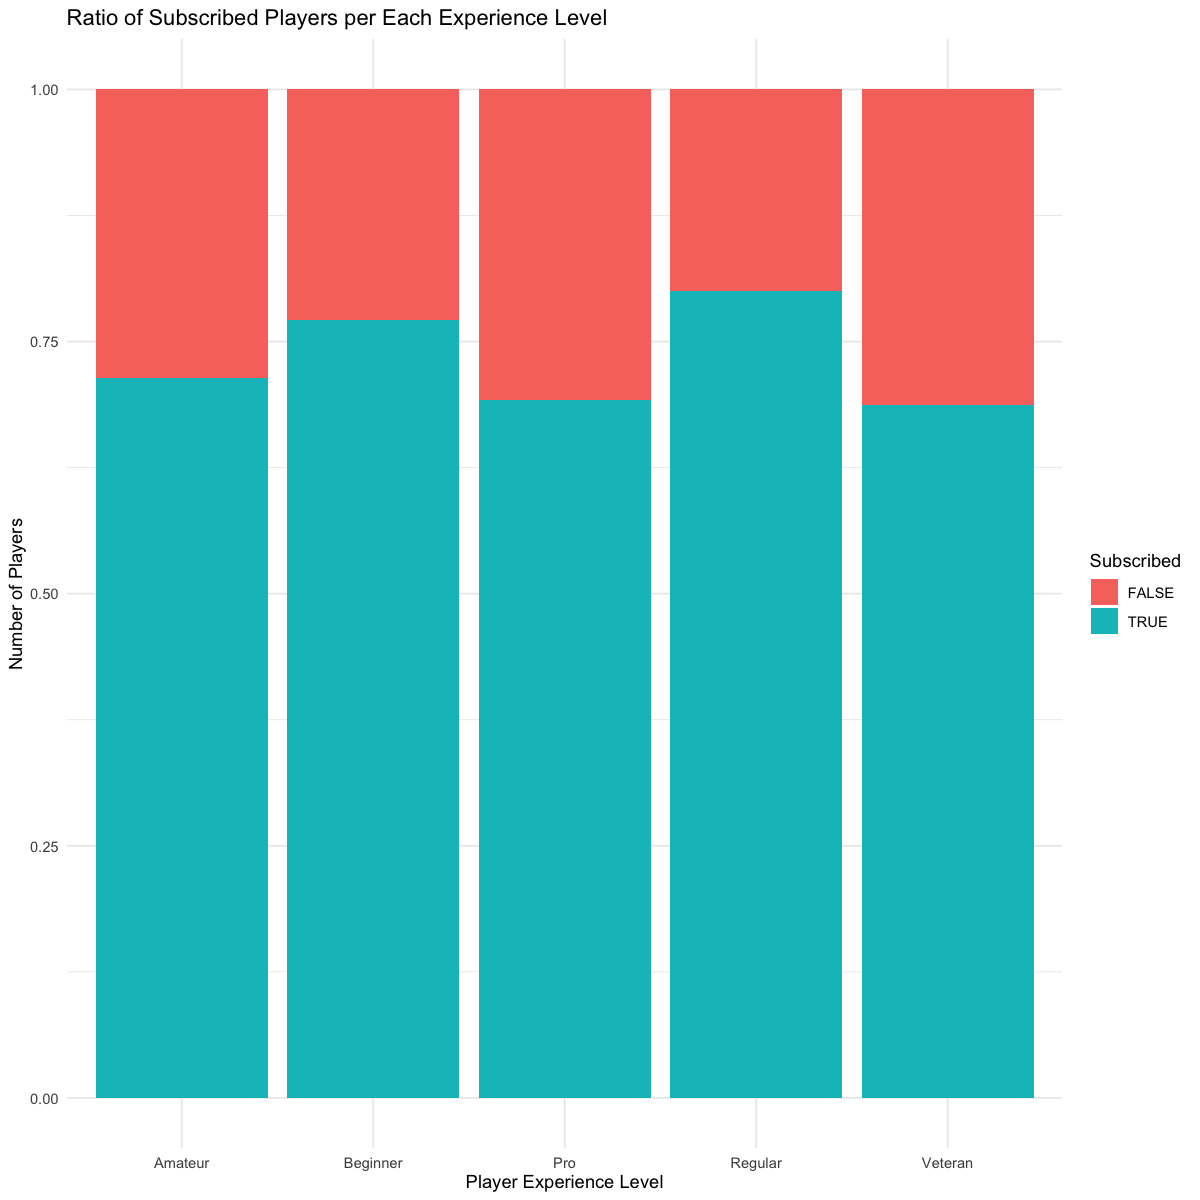

In [8]:
bar_plot_1 <- tidy_players |>
                ggplot(aes(x = experience, fill = subscribe)) +
                geom_bar(position = "fill") +
                labs(
                    title = "Ratio of Subscribed Players per Each Experience Level",
                    x = "Player Experience Level",
                    y = "Number of Players",
                    fill = "Subscribed"
                ) + 
                scale_y_continuous() +
                theme_minimal()

bar_plot_1

                         Figure 5.   

**Figure 5 Insights:**
* Regular players seem to have the highest ratio of subscribed players, but not by a large margin
* Veteran is the most experienced level but not the most subscribed ratio
* This suggest the relationship between experience and susbcription may be more complicated than a direct relationship between the two variables

#### Subscription Based on Gender

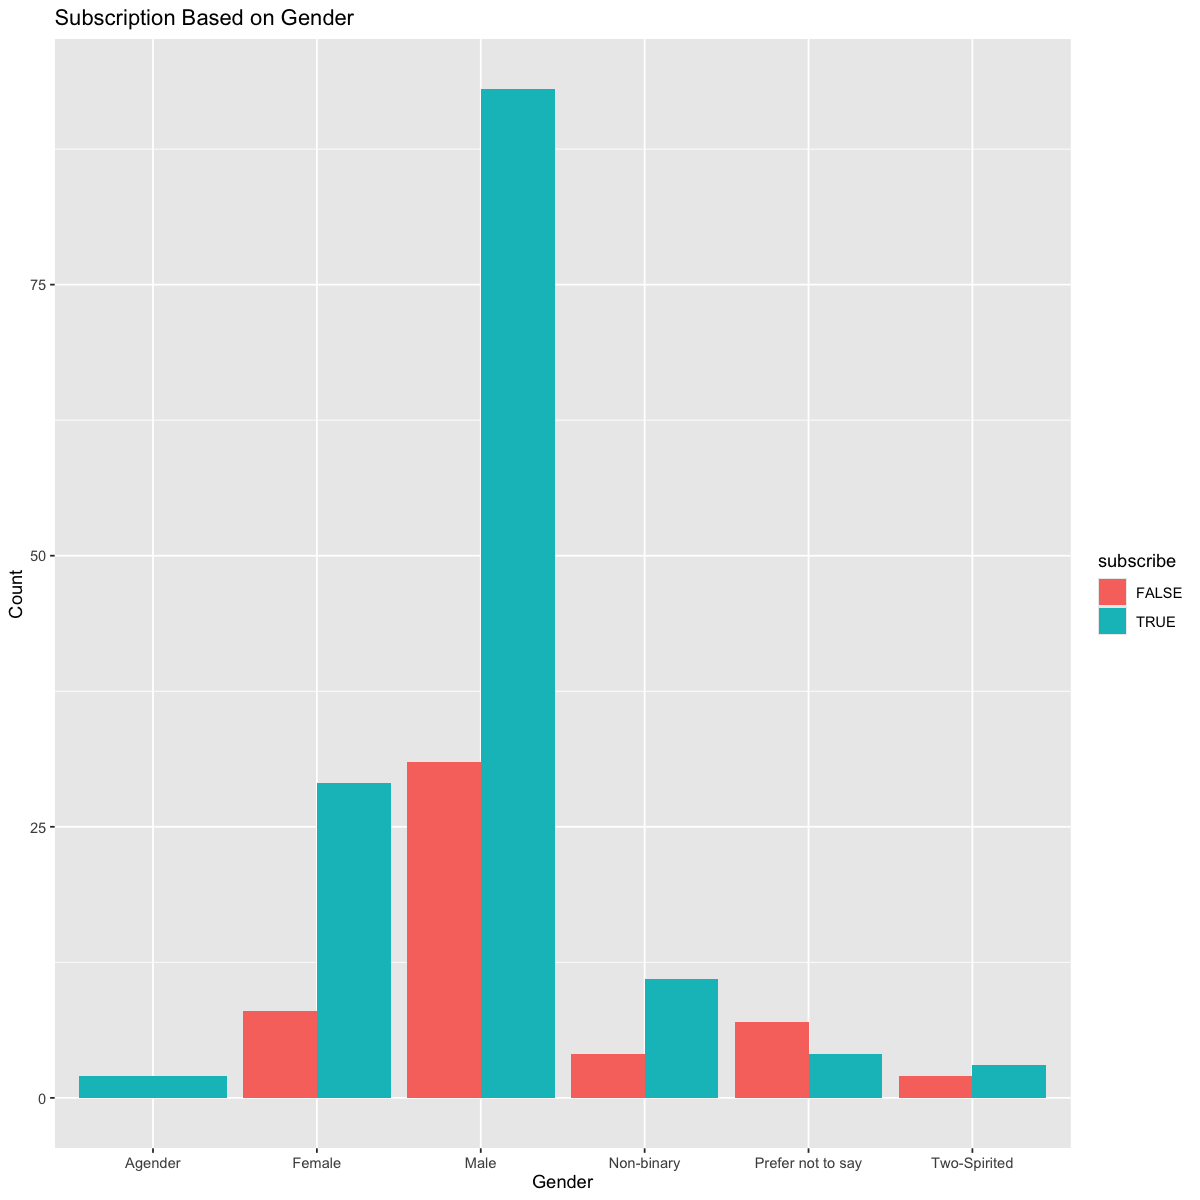

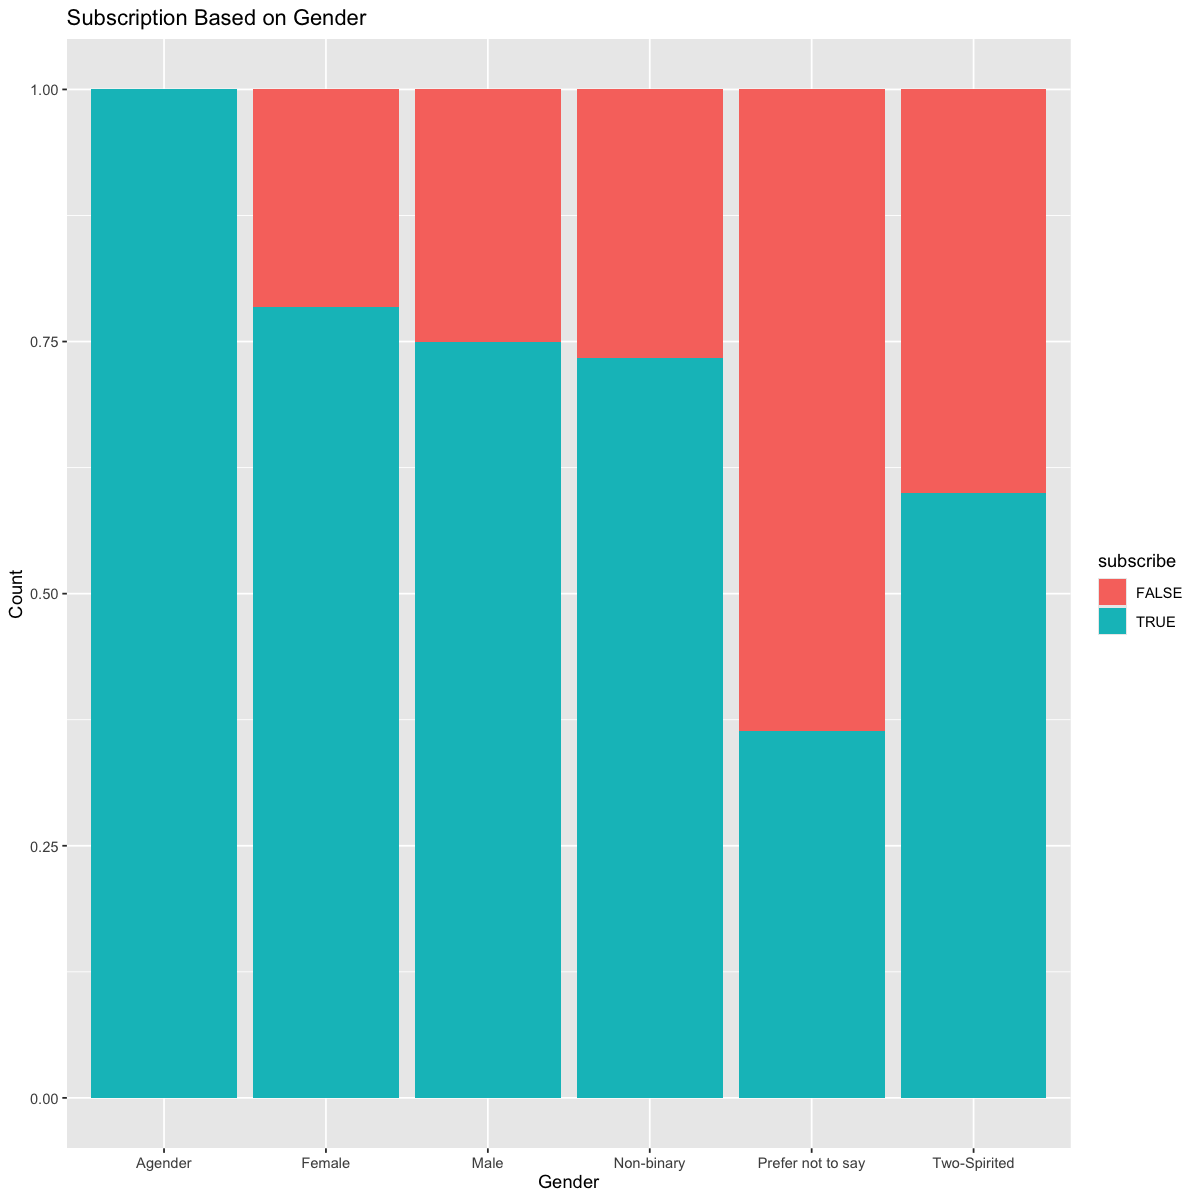

In [9]:
sub_on_gender <- tidy_players |>
                 ggplot(aes(x = gender, fill = subscribe)) +
                 geom_bar(position = "dodge") +
                 labs(title = "Subscription Based on Gender",
                 x = "Gender", y = "Count")

sub_on_gender

sub_on_gender_ratio <- tidy_players |>
                 ggplot(aes(x = gender, fill = subscribe)) +
                 geom_bar(position = "fill") +
                 labs(title = "Subscription Based on Gender",
                 x = "Gender", y = "Count")

sub_on_gender_ratio

                         Figure 6.

**Figure 6 Insights:**

* Male players have the highest subscription count, making them the dominant subscriber group
* Female players subscribe less overall, but their subscribe-to-non-subscribe ratio is similar to males
* Other gender minorities have outliers because of their low sample size

## Analysis with KNN classification

### With neighbors = 5

In [10]:
# Set seed because we are splitting the dataset with initial_split which is random
set.seed(6767)

# Split dataset into training and testing datasets
players_split <- initial_split(tidy_players, prop = 0.75, strata = subscribe)
players_train <- training(players_split)
players_test <- testing(players_split)

# Create recipe, with ONLY numerical variables
subscription_recipe <- recipe(subscribe ~ age + played_hours, players_train)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) |>
    set_engine("kknn") |>
    set_mode("classification")

subscription_fit <- workflow() |>
    add_recipe(subscription_recipe) |>
    add_model(knn_spec) |>
    fit(data = players_train)

subscription_predictions <- predict(subscription_fit, players_test) |>
    bind_cols(players_test)

# Print the metrics and confusion matrix for analysis
subscription_predictions |> metrics(truth = subscribe, estimate = .pred_class)
subscription_predictions |> conf_mat(truth = subscribe, estimate = .pred_class)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.51020408
kap,binary,-0.09497207


          Truth
Prediction FALSE TRUE
     FALSE     4   15
     TRUE      9   21

            Figure 7.

**Figure 7 Insights:**

- KNN (k = 5) reached **51%** accuracy, only slightly above random guessing.
- The model misclassified many cases, indicating weak separation between the classes.
- **Age** and **played_hours** are not strong predictors of subscription.
- KNN is likely limited by the small number of features and weak signals.

### 3-Fold Cross Validation

In [11]:
# Set seed since vfold_cv uses randomness
set.seed(6767)

players_vfold <- vfold_cv(players_train, v = 3, strata = subscribe)

subscription_resample_fit <- workflow() |>
    add_recipe(subscription_recipe) |>
    add_model(knn_spec) |>
    fit_resamples(resamples = players_vfold)

# Print results for the 3-fold validation
subscription_resample_fit |> collect_metrics()

.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
accuracy,binary,0.6476757,3,0.04514106,pre0_mod0_post0
brier_class,binary,0.2156746,3,0.01890151,pre0_mod0_post0
roc_auc,binary,0.6266382,3,0.04075826,pre0_mod0_post0


                            Figure 8.

**Figure 8 Insights:**

- 3-fold cross-validation gives **64% accuracy**, higher than the original **51%** KNN (K=5) result.
- **roc_auc** is **~0.62**, indicating only modest separation between the two classes.
- The model still struggles to distinguish subscribers vs. non-subscribers.

### Tuning K Value

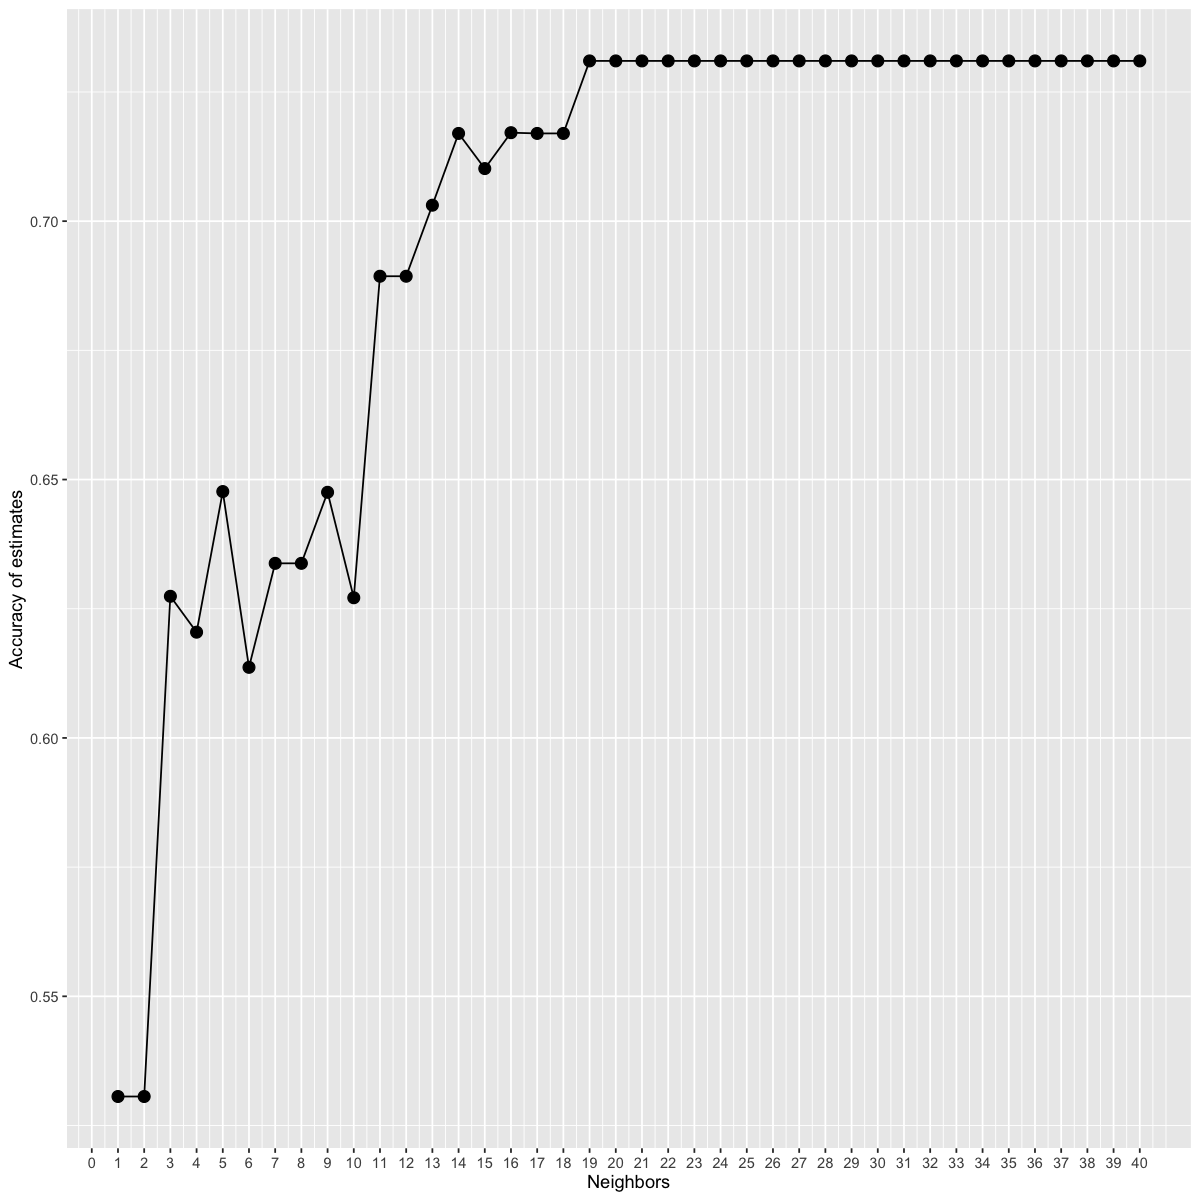

In [12]:
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

# Test for k values from 1 - 40, a pretty wide possible range
k_vals <- tibble(neighbors = seq(from = 1, to = 40, by = 1))

knn_results <- workflow() |>
    add_recipe(subscription_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = players_vfold, grid = k_vals) |>
    collect_metrics()

accuracies <- knn_results |>
    filter(.metric == "accuracy")

accuracies |> ggplot(aes(x = neighbors, y = mean)) +
    geom_point(size = 3) +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy of estimates") +
    scale_x_continuous(breaks = seq(from = 0, to = 40, by = 1))

                                            Figure 9.

**Figure 9 Insights:**

- Very small K values are highly sensitive to noise, causing unstable and low accuracy.
- As K increases, predictions become more stable and accuracy steadily improves.
- The curve flattens around **K ≈ 13–17**, where the model reaches its best performance.
- Beyond this range, large K values mostly rely on the majority class, reducing the model’s usefulness.
- **K ≈ 13–17** offers the best trade-off between stability and meaningful classification.


### With experience variable converted to numerical values

In [13]:
# Set seed because we are using initial_split and vfold_cv
set.seed(6767)

# See references section for citation [1]
# This code maps a factor variable to numerical values, which makes sense for experience level
# The same cannot really be done with gender, since its not clear how to quantify the values
experience_map <- c("Beginner"=0, "Amateur"=1, "Regular"=2, "Pro"=3, "Veteran"=4)

converted_players <- tidy_players |> mutate(experience_level = experience_map[as.character(experience)])

players_split <- initial_split(converted_players, prop = 0.75, strata = subscribe)
players_train <- training(players_split)
players_test <- testing(players_split)

players_vfold <- vfold_cv(players_train, v = 3, strata = subscribe)

subscription_recipe <- recipe(subscribe ~ age + played_hours + experience_level, converted_players) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

subscription_resample_fit <- workflow() |>
    add_recipe(subscription_recipe) |>
    add_model(knn_spec) |>
    fit_resamples(resamples = players_vfold)

subscription_resample_fit |> collect_metrics()

.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
accuracy,binary,0.6757370,3,0.009070295,pre0_mod0_post0
brier_class,binary,0.2313209,3,0.013868462,pre0_mod0_post0
roc_auc,binary,0.5356329,3,0.039532956,pre0_mod0_post0


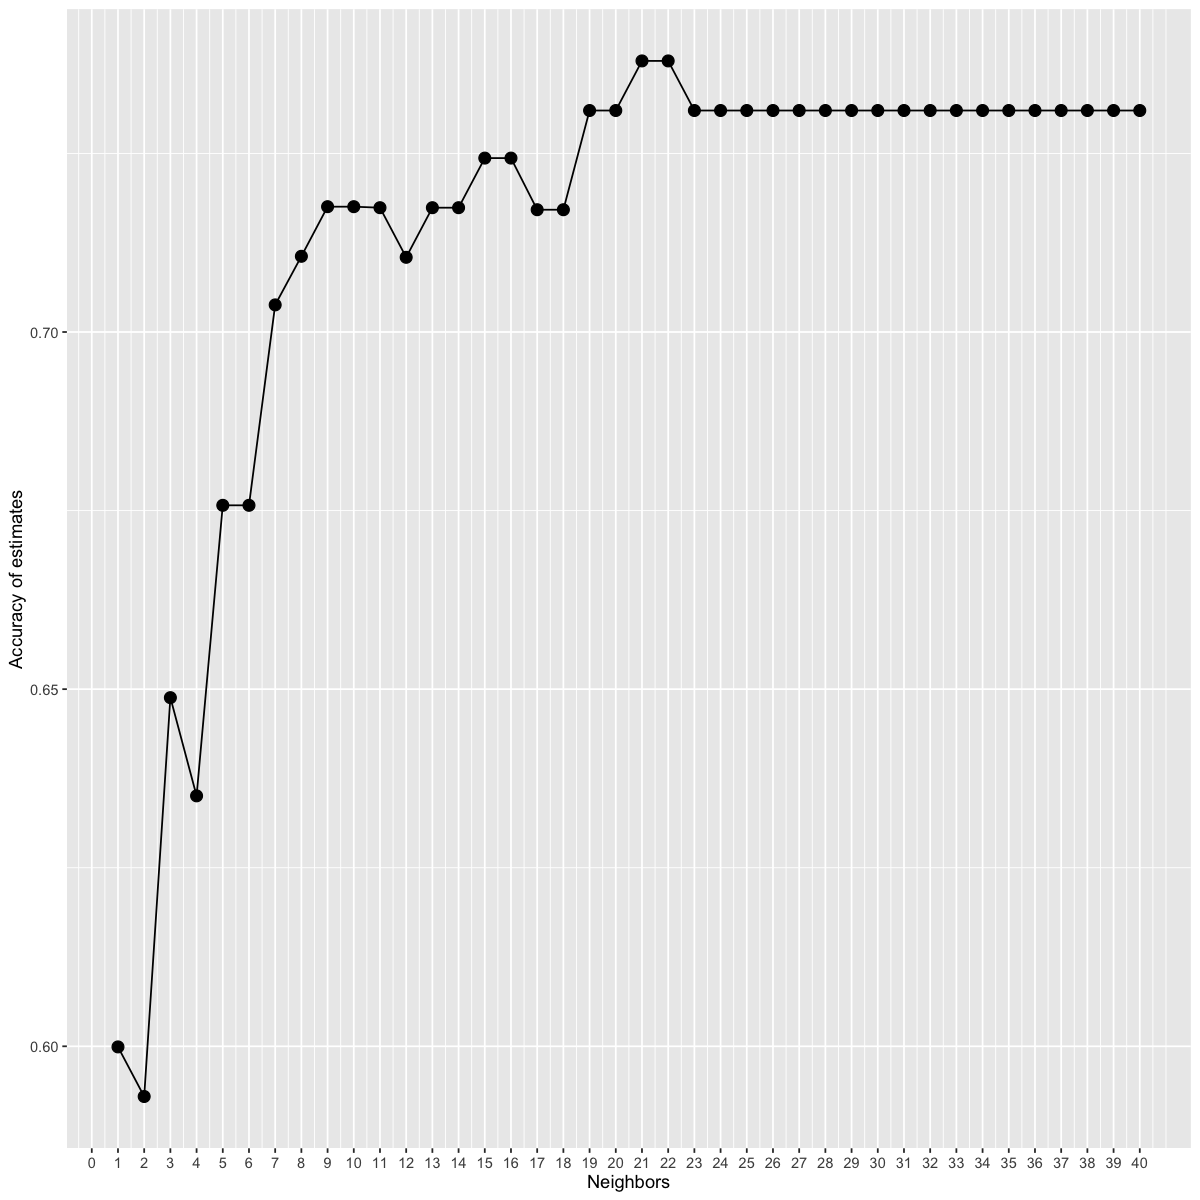

In [14]:
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

k_vals <- tibble(neighbors = seq(from = 1, to = 40, by = 1))

knn_results <- workflow() |>
    add_recipe(subscription_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = players_vfold, grid = k_vals) |>
    collect_metrics()

accuracies <- knn_results |>
    filter(.metric == "accuracy")

accuracies |> ggplot(aes(x = neighbors, y = mean)) +
    geom_point(size = 3) +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy of estimates") +
    scale_x_continuous(breaks = seq(from = 0, to = 40, by = 1))

                                                Figure 10.

**Figure 10 Insights:**

- The plot shows KNN accuracy after adding a numeric `experience_level` and applying scaling/centering.
- Overall accuracy is higher and the curve appears smoother than in the earlier version.
- Small K values remain unstable but perform better than before.
- Accuracy increases and stabilizes around **K = 10–20**, reaching about 0.73–0.77.
- Very large K values show a flat plateau, suggesting majority-class behavior.
- **K ≈ 11–18** provides a strong balance between stability and predictive accuracy.

## Discussion

This study investigated whether player **age**, **experience**, **gender**, and **played_hours** could predict subscription to a game-related newspaper. The exploratory data analysis indicated that **played_hours** was the most informative variable. Most non-subscribers accumulated very little playtime, usually between 0 and 10 hours, and almost none exceeded 13 hours. In contrast, subscribers displayed a much wider range of playtime, including several highly engaged players whose total hours exceeded 200. **Age** did not show meaningful differences between the two groups, as both subscribers and non-subscribers were mainly between 20 and 40 years old. **Gender** also contributed very limited predictive value. Although more male players subscribed in absolute numbers, the subscription proportion for male and female players was nearly the same. **Experience** presented a weak and non-linear pattern, since regular players subscribed slightly more often, while other categories, including Veteran players, did not differ substantially. These observations imply that subscription behavior is more strongly associated with long-term engagement than with demographic characteristics.

To evaluate these findings more formally, we compared two KNN models, which appear in **Figure 9** and **Figure 10**. The Basic KNN Model in **Figure 9** used only two predictors, **age** and **played_hours**, and applied no numerical transformation or scaling. This model achieved an accuracy of approximately 51 percent. Such performance indicates that age and total hours played alone cannot meaningfully distinguish subscribers from non-subscribers.

The Enhanced KNN Model in **Figure 10** introduced a numeric **experience** variable and applied centering and scaling to all predictors. After these adjustments, model performance improved considerably. Cross-validated accuracy increased to approximately 73%-77%, and the accuracy curve became more stable. The tuning results indicated that values of K between 11 and 18 offered the most reliable performance, since very small K values were sensitive to noise, while very large K values produced oversmoothed predictions. Compared with the Basic KNN Model, the Enhanced KNN Model demonstrates that simple feature engineering and preprocessing can significantly improve the ability of the classifier to capture differences in subscription behavior.

Although the enhanced model performed better, the predictive strength of the four variables remains limited. Most of the improvement came from variables related to engagement, while age and gender contributed little to the classification task. The dataset also contained a clear class imbalance, with more subscribers than non-subscribers, which can cause KNN to favor the majority class. As a result, even though the overall accuracy appears relatively high, the model may still struggle to correctly identify non-subscribers. Therefore, the performance should be interpreted with caution.

Several limitations should be acknowledged. The dataset is relatively small, with a sample size of 196 players, which may reduce the stability and generalizability of the model. The available features are also coarse and do not capture more detailed behavioral information. For example, total playtime does not reflect session frequency, interaction patterns, reward collection behavior, or mission progress, all of which may influence subscription decisions more directly.

Future work should collect a larger and more balanced dataset and incorporate more detailed behavioral variables, such as login frequency, session duration patterns, reward dynamics, or social interactions. It may also be useful to experiment with additional classification models, including logistic regression, decision trees, random forests, and boosted models. These extensions would help reveal the mechanisms behind subscription behavior and support the development of more robust predictive models.


## References

[1] https://stackoverflow.com/a/14559432